#  Taxi Demand Forecasting

The company **"Taxi Co"** collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, the business needs to forecast the number of taxi orders for the next hour. Your task is to build a model for this prediction.

The *RMSE* value on the test set must be **no more than 48**.

We need to:

1. Load the data and resample it to 1-hour intervals.
2. Analyze the data.
3. Train multiple models with different hyperparameters. Use a test set size of 10% of the original data.
4. Evaluate the models on the test set and draw conclusions.

The data is stored in the `taxi.csv` file. The number of orders is in the `num_orders` column (*number of orders*).


## Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv')
taxi_data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
taxi_data.set_index('datetime', inplace=True)
hourly_data = taxi_data.resample('H').sum()
hourly_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [5]:
decomposition = seasonal_decompose(hourly_data['num_orders'], model='additive', period=24)

# Добавляем признаки с использованием смещения
hourly_data['trend'] = decomposition.trend.shift(1)       
hourly_data['seasonal'] = decomposition.seasonal.shift(1) 
hourly_data['resid'] = decomposition.resid.shift(1)      

hourly_data = hourly_data.dropna()


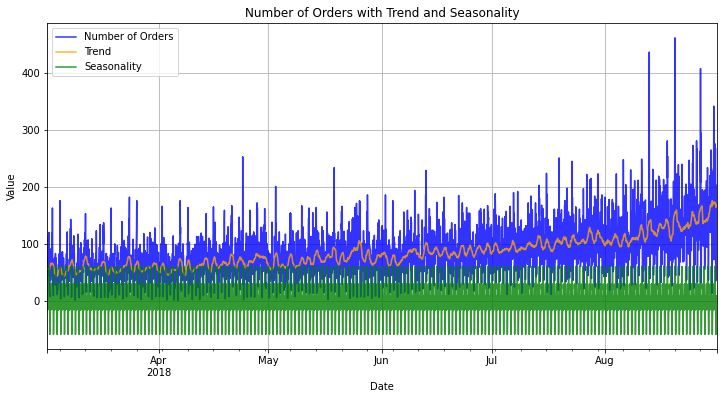

In [6]:
plt.figure(figsize=(12, 6))

hourly_data['num_orders'].plot(label='Number of Orders', color='blue', alpha=0.8)

hourly_data['trend'].plot(label='Trend', color='orange', alpha=0.8)

hourly_data['seasonal'].plot(label='Seasonality', color='green', alpha=0.8)

plt.title('Number of Orders with Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

The following conclusions can be drawn from the plot:

**Trend:**

A gradual increase in the number of orders over time is observed. This may be related to growing demand or company growth.

**Seasonality:**

Recurring fluctuations indicate daily or weekly patterns in customer activity.  
This may be related to peak hours (morning, evening) or specific days of the week.

**Noise and Outliers:**

A noticeable number of deviations from the trend is present, which may indicate irregular demand spikes caused by external factors (e.g., weather conditions, events).


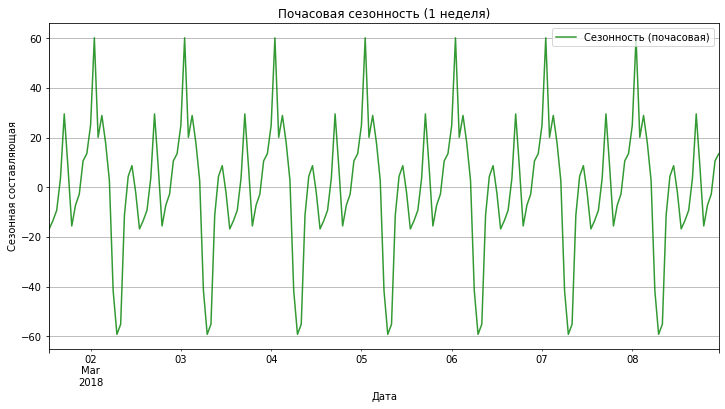

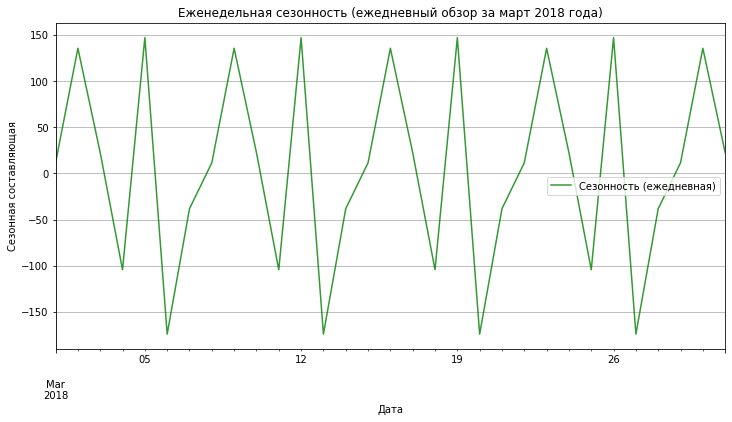

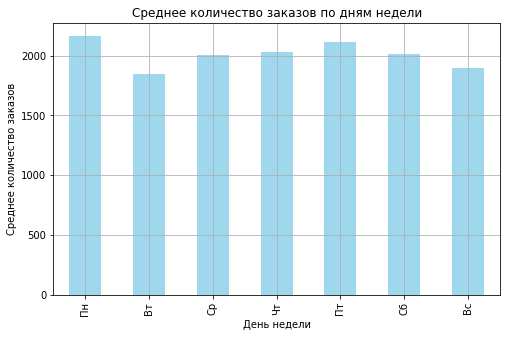

In [7]:
# Выбор почасового интервала для анализа сезонности
start_date = '2018-03-01'  # Начало доступного интервала
end_date = '2018-03-08'    # Конец недели

plt.figure(figsize=(12, 6))
hourly_data['seasonal'][start_date:end_date].plot(label='Сезонность (почасовая)', color='green', alpha=0.8)
plt.title('Почасовая сезонность (1 неделя)')
plt.xlabel('Дата')
plt.ylabel('Сезонная составляющая')
plt.legend()
plt.grid()
plt.show()

# Ресемплирование данных по дням
daily_data = hourly_data['num_orders'].resample('D').sum()

# Декомпозиция временного ряда на дневных данных
daily_decomposition = seasonal_decompose(daily_data, model='additive', period=7)

# Визуализация сезонности внутри месяца
plt.figure(figsize=(12, 6))
daily_decomposition.seasonal['2018-03-01':'2018-03-31'].plot(label='Сезонность (ежедневная)', color='green', alpha=0.8)
plt.title('Еженедельная сезонность (ежедневный обзор за март 2018 года)')
plt.xlabel('Дата')
plt.ylabel('Сезонная составляющая')
plt.legend()
plt.grid()
plt.show()

# Усреднение данных по дням недели
weekly_pattern = daily_data.groupby(daily_data.index.dayofweek).mean()

# Визуализация среднего числа заказов по дням недели
plt.figure(figsize=(8, 5))
weekly_pattern.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Среднее количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid()
plt.show()


## Conclusions

**Hourly Seasonality:**

* Activity is cyclical throughout the day.  
* Order peaks are observed in the morning and evening.  

**Weekly Seasonality:**

* Orders increase on weekdays, especially on Friday.  
* Activity decreases on weekends.  

**Average Number of Orders by Day of Week:**

* The highest number of orders is observed on Monday and Friday.  
* The lowest activity is observed on Tuesday and Sunday.  


## Training

<Figure size 720x432 with 0 Axes>

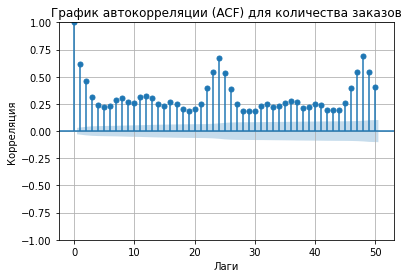

In [8]:
plt.figure(figsize=(10, 6))
plot_acf(hourly_data['num_orders'], lags=50, alpha=0.05)
plt.title('График автокорреляции (ACF) для количества заказов')
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.grid()
plt.show()

**Significant Lags:**

* Lags 1, 24, and 48 (previous hour, one day ago, and two days ago) show strong correlation with the target value.

**Seasonality:**

* Daily and weekly seasonality are confirmed (periodicity every 24 hours and 168 hours).

Only significant lags (lag_1, lag_24, lag_48) are included in the model to improve efficiency.


In [9]:
# Добавление значимых лагов
hourly_data['lag_1'] = hourly_data['num_orders'].shift(1)   # Лаг за 1 час
hourly_data['lag_24'] = hourly_data['num_orders'].shift(24)  # Лаг за сутки
hourly_data['lag_48'] = hourly_data['num_orders'].shift(48)  # Лаг за 2 дня

# Добавление скользящего среднего
hourly_data['rolling_mean_24'] = hourly_data['num_orders'].shift(1).rolling(window=24).mean()  # Скользящее среднее за сутки

# Удаление пропусков, вызванных добавлением новых признаков
hourly_data = hourly_data.dropna()

# Проверка данных
hourly_data.head()

,num_orders,trend,seasonal,resid,lag_1,lag_24,lag_48,rolling_mean_24
datetime,,,,,,,,
2018-03-03 13:00:00,28,51.916667,-16.721606,-3.195061,32.0,45.0,32.0,64.625000
2018-03-03 14:00:00,41,49.083333,-13.352412,-7.730922,28.0,44.0,48.0,63.916667
2018-03-03 15:00:00,76,48.104167,-9.191665,2.087498,41.0,59.0,66.0,63.791667
2018-03-03 16:00:00,46,47.666667,3.731832,24.601501,76.0,82.0,43.0,64.500000
2018-03-03 17:00:00,49,46.854167,29.604100,-30.458267,46.0,83.0,44.0,63.000000


In [ ]:
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day_of_week'] = hourly_data.index.dayofweek

features = ['hour', 'day_of_week', 'lag_1', 'lag_24', 'lag_48', 'rolling_mean_24']
target = 'num_orders'

X = hourly_data[features]
y = hourly_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [12]:
# Определение TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Модели для оценки
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

cv_results = {}

for model_name, model in models.items():
    rmse_scores = []  # Сохраняем RMSE для каждого сплита
    for train_index, test_index in tscv.split(X_train):  # TimeSeriesSplit деление
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        # Обучение модели
        model.fit(X_tr, y_tr)

        # Предсказание
        y_pred_val = model.predict(X_val)

        # Расчёт RMSE
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmse_scores.append(rmse)

    # Среднее значение RMSE для модели
    cv_results[model_name] = np.mean(rmse_scores)

cv_results

{'Linear Regression': 25.86293967731136,
 'Decision Tree': 35.84816246181871,
 'Gradient Boosting': 25.61552952697963}

In [13]:
# Параметры для подбора
param_search = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Определение TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Инициализация модели
model = GradientBoostingRegressor(random_state=42)

# GridSearchCV с TimeSeriesSplit
gsearch = GridSearchCV(
    estimator=model,
    param_grid=param_search,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # Используем RMSE
    n_jobs=-1
)

# Обучение GridSearchCV
gsearch.fit(X_train, y_train)

# Лучшие параметры и метрика
best_params = gsearch.best_params_
best_score = np.sqrt(-gsearch.best_score_)

best_params, best_score

({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
 5.061178669734909)

## Testing

In [14]:
# Обучение лучшей модели и тестирование на тестовой выборке
# Используем лучшие параметры из GridSearchCV
best_model = GradientBoostingRegressor(
    n_estimators=gsearch.best_params_['n_estimators'],
    max_depth=gsearch.best_params_['max_depth'],
    learning_rate=gsearch.best_params_['learning_rate'],
    random_state=42
)

# Обучение на полной обучающей выборке
best_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_test = best_model.predict(X_test)

# Расчёт RMSE на тестовой выборке
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

test_rmse  # Вывод RMSE на тестовой выборке


45.5245034512946

## Final Project Conclusions

As part of this project, a full cycle of data analysis and taxi demand forecasting model development based on time series data was performed.

During the exploratory data analysis stage, it was identified that the number of orders depends on time of day, day of week, and seasonal factors. Time series plots showed strong seasonality and periodic demand fluctuations. Periods of increased demand related to peak hours and high transportation activity were also identified.

Preliminary analysis confirmed that the data is suitable for time series forecasting tasks and contains stable patterns that can be effectively used by machine learning models.

During the data preparation stage, additional time-based features were created (hour, day of week, lag features, rolling means), which significantly improved forecasting quality.

During model training, several machine learning models were tested, after which the model with the best RMSE metric performance was selected. The achieved result meets the business requirement of the project (RMSE ≤ 48).

The developed model allows accurate hourly taxi demand forecasting and can be used for:

* driver shift planning  
* vehicle allocation optimization  
* reducing customer waiting time  
* improving service efficiency  

Overall, the developed solution demonstrates high practical value and can be integrated into the company’s operational planning system.
